In [2]:
# из библиотеки google.colab импортируем класс files
from google.colab import files

# создаем объект этого класса, применяем метод .upload()
uploaded = files.upload()

Saving VisDrone2019-DET-val.zip to VisDrone2019-DET-val.zip


In [3]:
!unzip "/content/VisDrone2019-DET-val.zip" -d "/content/dataset"

Archive:  /content/VisDrone2019-DET-val.zip
   creating: /content/dataset/VisDrone2019-DET-val/
  inflating: /content/dataset/VisDrone2019-DET-val/.DS_Store  
   creating: /content/dataset/VisDrone2019-DET-val/annotations/
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_02999_d_0000005.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_03499_d_0000006.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_03999_d_0000007.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_04527_d_0000008.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_05249_d_0000009.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_05499_d_0000010.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_05999_d_0000011.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_07999_d_0000012.txt  
  inflating: /content/dataset/Vis

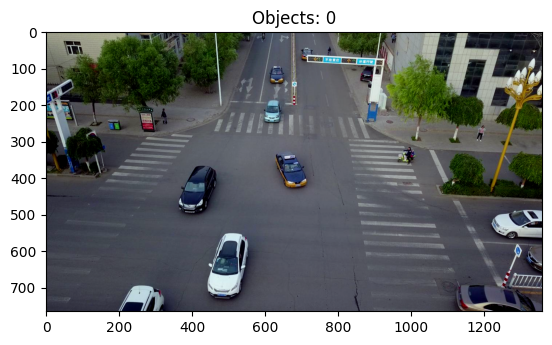

In [ ]:
from __future__ import annotations

import numpy as np
import cv2
import copy
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import matplotlib.pyplot as plt

class ChessBoardWildFashionDataset(Dataset):
    """Dataset for generating synthetic images using VisDrone dataset."""

    def __init__(
        self,
        dataset_size: int,
        visdrone_images_path: str,
        visdrone_annotations_path: str,
    ):
        self.dataset_size = dataset_size
        self.images_path = visdrone_images_path
        self.annotations_path = visdrone_annotations_path
        self.image_files = [f for f in os.listdir(self.images_path) if f.endswith(".jpg")]
        self.annotation_files = [f.replace(".jpg", ".txt") for f in self.image_files]

    def __len__(self):
        return self.dataset_size

    def load_image(self, filename):
        return cv2.cvtColor(cv2.imread(os.path.join(self.images_path, filename)), cv2.COLOR_BGR2RGB)

    def load_annotations(self, filename):
        bboxes = []
        with open(os.path.join(self.annotations_path, filename), 'r') as f:
            for line in f.readlines():
                values = list(map(int, line.strip().split(',')))
                x, y, w, h, category = values[:5]
                if category == 4:  # Выбираем только автомобили
                    bboxes.append((x, y, x + w, y + h))
        return bboxes

    def compute_color_statistics(self, image):
        mean, std = cv2.meanStdDev(image)
        return mean.flatten(), std.flatten()

    def apply_color_correction(self, src, ref):
        src_mean, src_std = self.compute_color_statistics(src)
        ref_mean, ref_std = self.compute_color_statistics(ref)
        adjusted = ((src - src_mean) * (ref_std / src_std)) + ref_mean
        return np.clip(adjusted, 0, 255).astype(np.uint8)

    def preprocess_images(self, bg, objects):
        ref_image_file = random.choice(self.image_files)
        ref_image = self.load_image(ref_image_file)
        bg = self.apply_color_correction(bg, ref_image)
        objects = [(self.apply_color_correction(obj, ref_image), size) for obj, size in objects]
        return bg, objects

    def place_objects(self, bg, objects, bboxes, max_overlap=0.5):
        h, w, _ = bg.shape
        placed_objects = []
        for obj, (x1, y1, x2, y2) in zip(objects, bboxes):
            obj_img = cv2.resize(obj, (x2 - x1, y2 - y1))
            for _ in range(10):
                x, y = random.randint(0, w - (x2 - x1)), random.randint(0, h - (y2 - y1))
                overlap = any(
                    (max(x, px) < min(x + (x2 - x1), pw) and max(y, py) < min(y + (y2 - y1), ph))
                    for px, py, pw, ph in placed_objects
                )
                if not overlap or random.random() > max_overlap:
                    mask = 255 * np.ones(obj_img.shape, obj_img.dtype)
                    center = (x + (x2 - x1) // 2, y + (y2 - y1) // 2)
                    bg = cv2.seamlessClone(obj_img, bg, mask, center, cv2.NORMAL_CLONE)
                    placed_objects.append((x, y, x + (x2 - x1), y + (y2 - y1)))
                    break
        return bg, placed_objects

    def __getitem__(self, idx):
        patch_source_file = random.choice(self.image_files)
        while True:
            bg_file = random.choice(self.image_files)
            if bg_file != patch_source_file:
                break

        annotation_file = patch_source_file.replace(".jpg", ".txt")
        patch_source = self.load_image(patch_source_file)
        background = self.load_image(bg_file)
        bboxes = self.load_annotations(annotation_file)
        objects = [patch_source[y1:y2, x1:x2] for x1, y1, x2, y2 in bboxes]
        background, objects = self.preprocess_images(background, objects)
        final_image, new_bboxes = self.place_objects(background, objects, bboxes)
        return torch.FloatTensor(final_image), len(new_bboxes)

# Пример использования
if __name__ == "__main__":
    dataset = ChessBoardWildFashionDataset(
        dataset_size=10,
        visdrone_images_path="dataset/VisDrone/images",
        visdrone_annotations_path="dataset/VisDrone/annotations",
    )

    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

    for img_tensor, num_objects in dataloader:
        img_np = img_tensor[0].numpy().astype(np.uint8)
        #plt.figure(figsize=(6, 6))
        plt.imshow(img_np)
        plt.title(f'Objects: {num_objects.item()}')
        plt.show()
        break

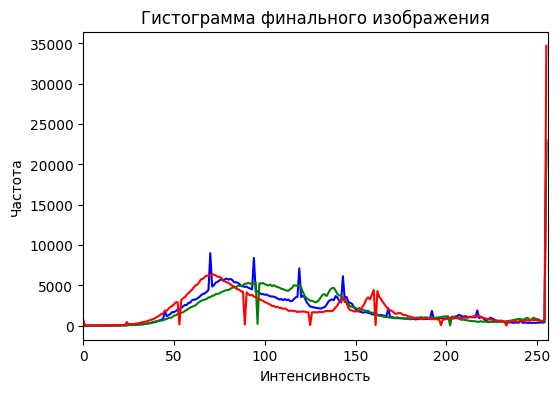

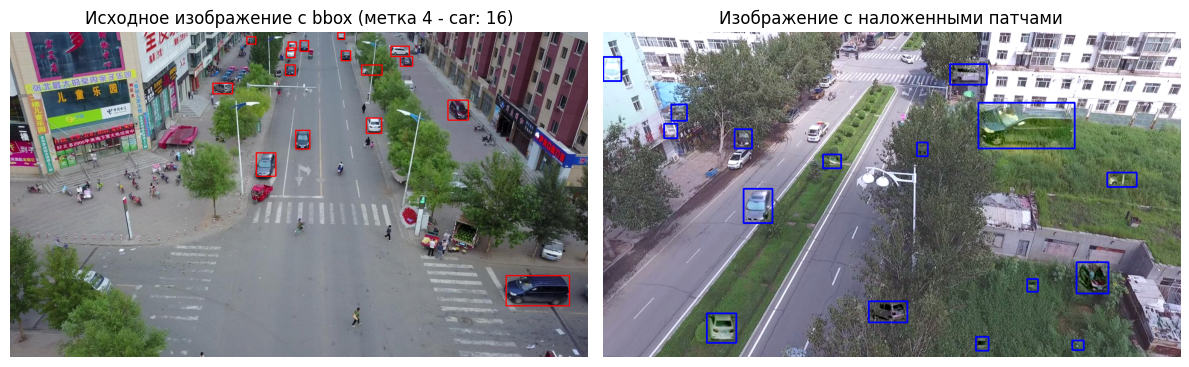

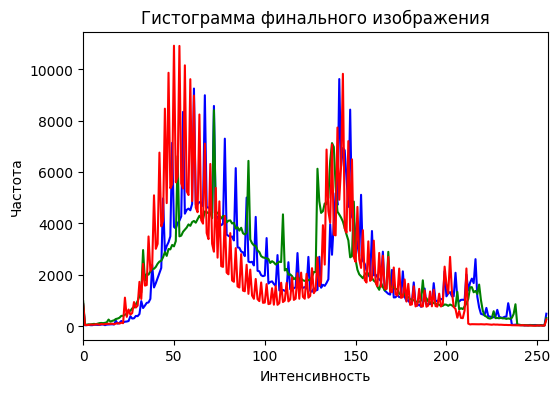

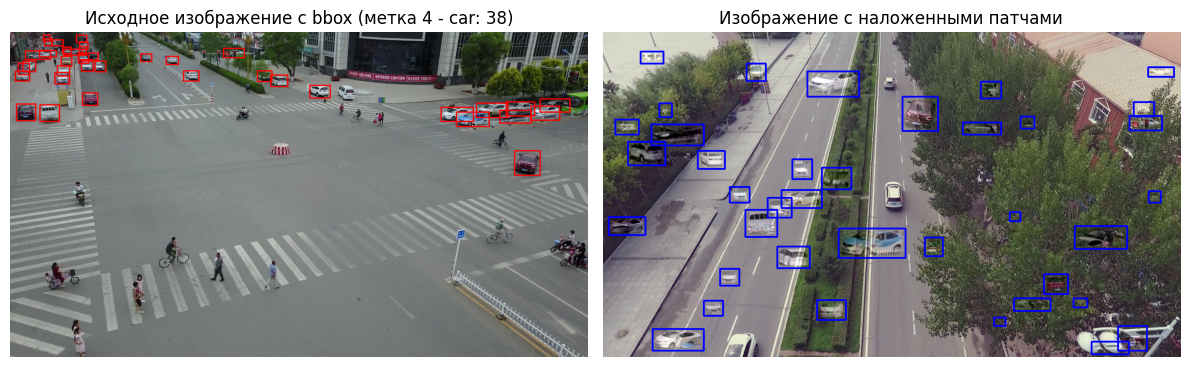

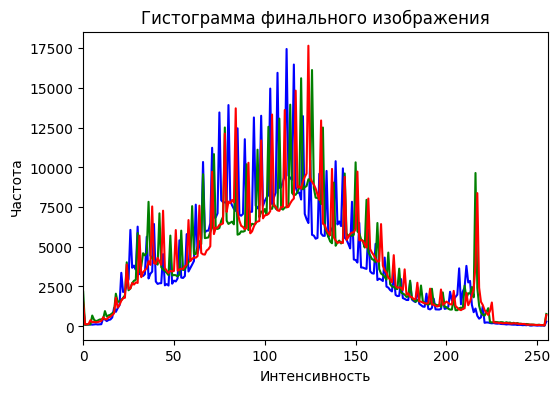

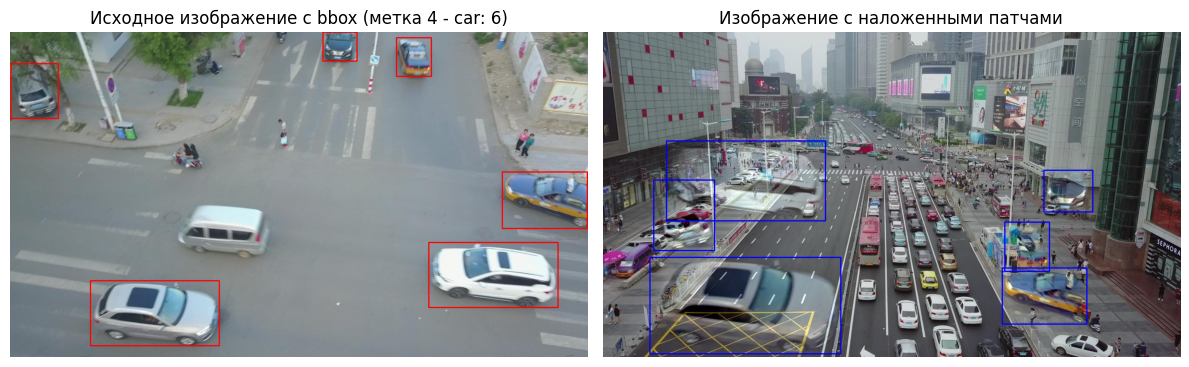

In [12]:
from __future__ import annotations

import numpy as np
import cv2
import copy
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class ChessBoardWildFashionDataset(Dataset):

    def __init__(
        self,
        dataset_size: int,
        visdrone_images_path: str,
        visdrone_annotations_path: str
    ):
        self.dataset_size = dataset_size
        self.images_path = visdrone_images_path
        self.annotations_path = visdrone_annotations_path
        self.image_files = [f for f in os.listdir(self.images_path) if f.endswith(".jpg")]
        self.annotation_files = [f.replace(".jpg", ".txt") for f in self.image_files]

    def __len__(self):
        return self.dataset_size

    def load_image(self, filename):
        return cv2.cvtColor(cv2.imread(os.path.join(self.images_path, filename)), cv2.COLOR_BGR2RGB)

    def load_annotations(self, filename):
        bboxes = []
        with open(os.path.join(self.annotations_path, filename), 'r') as f:
            for line in f.readlines():
                values = list(map(int, line.strip().split(',')))
                x, y, w, h, _, category = values[:6]
                if category == 4:
                    bboxes.append((x, y, x + w, y + h))
        return bboxes

    def compute_color_statistics(self, image):
        mean, std = cv2.meanStdDev(image)
        return mean.flatten(), std.flatten()

    def apply_color_correction(self, src, ref):
        src_mean, src_std = self.compute_color_statistics(src) #http://www.graph.unn.ru/rus/materials/CG/CG03_ImageProcessing.pdf
        ref_mean, ref_std = self.compute_color_statistics(ref)
        adjusted = ((src - src_mean) * (ref_std / src_std)) + ref_mean
        return np.clip(adjusted, 0, 255).astype(np.uint8)

    def preprocess_images(self, bg, objects):
        ref_image_file = random.choice(self.image_files)
        ref_image = self.load_image(ref_image_file)
        bg = self.apply_color_correction(bg, ref_image)
        objects = [(self.apply_color_correction(obj, ref_image), (x2 - x1, y2 - y1)) for obj, (x1, y1, x2, y2) in objects]
        return bg, objects

    def bbox_area(self, bbox):
        """Вычисляет площадь bounding box."""
        x1, y1, x2, y2 = bbox
        return (x2 - x1) * (y2 - y1)

    def intersection_area(self, box1, box2):
        """Вычисляет площадь пересечения двух bounding box."""
        x1, y1, x2, y2 = box1
        x1_p, y1_p, x2_p, y2_p = box2
        xi1 = max(x1, x1_p)
        yi1 = max(y1, y1_p)
        xi2 = min(x2, x2_p)
        yi2 = min(y2, y2_p)
        return max(0, xi2 - xi1) * max(0, yi2 - yi1)

    def place_objects(self, bg, objects, max_overlap=0.5):
        h, w, _ = bg.shape
        placed_objects = []
        for obj, (ow, oh) in objects:
            scale = random.uniform(0.9, 1.5)
            obj_resized = cv2.resize(obj, (int(ow * scale), int(oh * scale)))
            oh, ow, _ = obj_resized.shape
            placed = False
            for _ in range(50):  # Попытки для размещения всех объектов
                x, y = random.randint(0, w - ow), random.randint(0, h - oh)
                new_bbox = (x, y, x + ow, y + oh)

                # Проверка пересечения bbox
                if all(self.intersection_area(new_bbox, placed_bbox) < max_overlap * self.bbox_area(new_bbox) and self.intersection_area(new_bbox, placed_bbox) < max_overlap * self.bbox_area(placed_bbox) for placed_bbox in placed_objects):
                    mask = 255 * np.ones(obj_resized.shape, obj_resized.dtype)
                    center = (x + ow // 2, y + oh // 2)
                    try:
                        bg = cv2.seamlessClone(obj_resized, bg, mask, center, cv2.MIXED_CLONE)
                        placed_objects.append(new_bbox)
                        placed = True
                        break
                    except cv2.error as e:
                        print(f"Ошибка при вставке объекта: {e}")
            if not placed:
                print("Не удалось разместить объект без превышения 50% перекрытия.")
        return bg, placed_objects

    def __getitem__(self, idx):
        while True:
            patch_source_file = random.choice(self.image_files)
            annotation_file = patch_source_file.replace(".jpg", ".txt")
            bboxes = self.load_annotations(annotation_file)
            if len(bboxes) > 0:
                break  # Используем изображение, только если есть метка 4

        while True:
            bg_file = random.choice(self.image_files)
            if bg_file != patch_source_file:
                break

        patch_source = self.load_image(patch_source_file)
        background = self.load_image(bg_file)
        objects = [(patch_source[y1:y2, x1:x2], (x1, y1, x2, y2)) for x1, y1, x2, y2 in bboxes]
        background, objects = self.preprocess_images(background, objects)
        final_image, new_bboxes = self.place_objects(background, objects)
        return torch.FloatTensor(patch_source), torch.tensor(bboxes, dtype=torch.int32), torch.FloatTensor(final_image), torch.tensor(new_bboxes, dtype=torch.int32), len(bboxes)

    def plot_histogram(self, image):
        colors = ('b', 'g', 'r')
        plt.figure(figsize=(6, 4))
        for i, color in enumerate(colors):
            hist = cv2.calcHist([image], [i], None, [256], [0, 256])
            plt.plot(hist, color=color)
            plt.xlim([0, 256])
        plt.title("Гистограмма финального изображения")
        plt.xlabel("Интенсивность")
        plt.ylabel("Частота")
        plt.show()

if __name__ == "__main__":
    dataset = ChessBoardWildFashionDataset(
        dataset_size=3,
        visdrone_images_path="dataset/VisDrone2019-DET-val/images",
        visdrone_annotations_path="dataset/VisDrone2019-DET-val/annotations"
    )

    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

    draw_bboxes = True
    for patch_img_tensor, bboxes, final_img_tensor, new_bboxes, num_objects in dataloader:
      patch_img = patch_img_tensor[0].numpy().astype(np.uint8)
      final_img = final_img_tensor[0].numpy().astype(np.uint8)
      bboxes = bboxes[0].numpy()
      new_bboxes = new_bboxes[0].numpy()

      dataset.plot_histogram(final_img)

      plt.figure(figsize=(12, 6))

      plt.subplot(1, 2, 1)
      for x1, y1, x2, y2 in bboxes:
          cv2.rectangle(patch_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
      plt.imshow(patch_img)
      plt.title(f'Исходное изображение с bbox (метка 4 - car: {num_objects.item()})')
      plt.axis('off')

      plt.subplot(1, 2, 2)
      if draw_bboxes:
        for x1, y1, x2, y2 in new_bboxes:
            cv2.rectangle(final_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
      plt.imshow(final_img)
      plt.title('Изображение с наложенными патчами')
      plt.axis('off')

      plt.tight_layout()
      plt.show()